spark-submit --master yarn --deploy-mode cluster  --conf spark.yarn.submit.waitAppCompletion=false --conf spark.serializer=org.apache.spark.serializer.KryoSerializer --conf spark.speculation=false --conf spark.executorEnv.LANG=en_US.UTF-8 --conf spark.yarn.appMasterEnv.LANG=en_US.UTF-8 --driver-cores 20 --driver-memory 55G --num-executors 30 --executor-cores 15 --executor-memory 30G ./covid/py/get-summary-statistics-pyspark.py

In [1]:
import os
from glob import glob
import pandas as pd
from timeit import default_timer as timer

from pyspark.sql import SparkSession
from pyspark.sql.functions import udf,desc,row_number,col,year,month,dayofmonth,dayofweek,to_timestamp,size,isnan,lit,date_format,to_timestamp
from pyspark.sql.types import MapType, StringType, IntegerType, StructType, StructField, FloatType, ArrayType, DoubleType

In [2]:
try:
    spark
except NameError:
    spark=SparkSession.builder.appName("").getOrCreate()

In [3]:
source='cuebiq'
country='MX'

if os.getenv('CLUSTER')=='PRINCE':
    path_to_data='/scratch/spf248/covid/data'
    %matplotlib inline
    import matplotlib.pyplot as plt
    import seaborn as sns
else:
    path_to_data='/user/spf248/covid/data'
    import matplotlib as mpl
    if os.environ.get('DISPLAY','') == '':
        mpl.use('Agg')
    import matplotlib.pyplot as plt
    import seaborn as sns
    
date_range=pd.Series(sorted([
pd.to_datetime(x.split('/')[-1][:-2],format='%Y%m%d') 
for x in glob(os.path.join(path_to_data,source,'s3',country,'2020*'))]))

activity_threshold=(date_range.shape[0]+1)*3//4
print('activity_threshold:',activity_threshold)

/share/apps/anaconda3/2019.10/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


activity_threshold: 66


# Users Activity

In [4]:
users=spark.read.parquet(os.path.join(path_to_data,source,'aggregates',country,'users_profile'))
users.cache()

DataFrame[cuebiq_id: string, n_days: bigint, n_pings: bigint, n_personal: bigint, device_type: float]

In [5]:
print('Compute Users Statistics')
start = timer()

n_days=users.select('n_days').groupby('n_days').count().orderBy(desc('n_days')).toPandas()
n_pings=users.select('n_pings').groupby('n_pings').count().orderBy(desc('n_pings')).toPandas()
n_pings_active=users.filter(users['n_days']>=activity_threshold).groupby('n_pings').count().orderBy(desc('n_pings')).toPandas()
pct_device=(users.groupby('device_type').count().toPandas().dropna().set_index('device_type')['count']/n_days['count'].sum()).round(2)
n_personal=users.groupby('n_personal').count().toPandas()

print("Done in", round(timer()-start), "sec")

Compute Users Statistics
Done in 31 sec


In [6]:
print('# Users:', n_days['count'].sum())
print('# Daily Users:', n_days.loc[n_days['n_days']>=activity_threshold,'count'].sum())
print('# Pings:', (n_pings['n_pings']*n_pings['count']).sum())
print('# Pings of Daily Users:', (n_pings_active['n_pings']*n_pings_active['count']).sum())
print('% Device Type:', pct_device)

# Users: 301967
# Daily Users: 126143
# Pings: 926562305
# Pings of Daily Users: 616332172
% Device Type: device_type
1.0    0.08
0.0    0.92
Name: count, dtype: float64


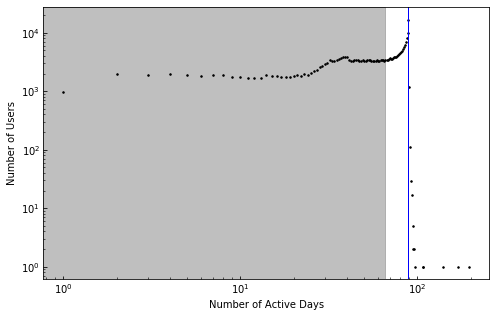

In [8]:
fig,ax=plt.subplots(figsize=(8,5))
n_days.set_index('n_days')['count'].plot(ax=ax,style='.',color='k', markersize=3)
ax.set_yscale('log')
ax.set_xscale('log')
ax.tick_params(which='both',direction='in',pad=3)
ax.set_xlabel('Number of Active Days')
ax.set_ylabel('Number of Users')
ax.axvline(x=(date_range.max()-date_range.min()).days+1, color='b', linewidth=1)
ax.axvspan(0, activity_threshold, alpha=0.5, color='grey')
plt.savefig(os.path.join(path_to_data+'/../fig',country,'number-of-active-days.pdf'),bbox_inches='tight')

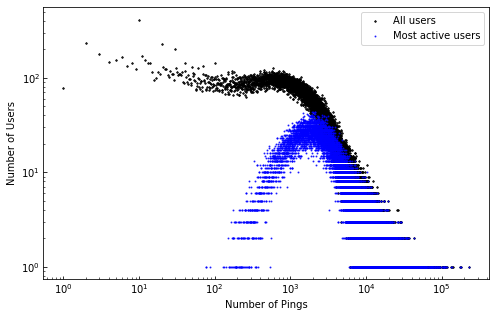

In [9]:
fig,ax=plt.subplots(figsize=(8,5))
n_pings.set_index('n_pings')['count'].plot(ax=ax,style='*',markersize=2,alpha=0.75,color='k',label='All users')
n_pings_active.set_index('n_pings')['count'].plot(ax=ax,style='.',markersize=2,alpha=0.75,color='b',label='Most active users')
ax.set_yscale('log')
ax.set_xscale('log')
ax.tick_params(which='both',direction='in',pad=3)
ax.set_xlabel('Number of Pings')
ax.set_ylabel('Number of Users')
ax.legend(loc='best')
plt.savefig(os.path.join(path_to_data+'/../fig',country,'number-of-pings.pdf'),bbox_inches='tight')

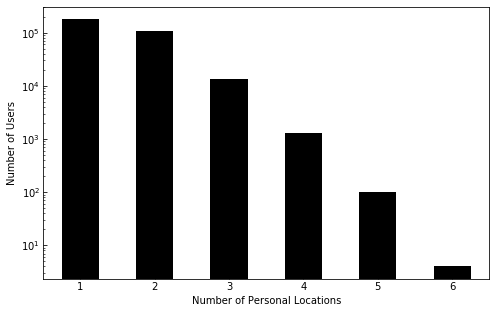

In [10]:
fig,ax=plt.subplots(figsize=(8,5))
n_personal.set_index('n_personal')['count'].sort_index().plot(ax=ax,kind='bar',color='k')
ax.tick_params(which='both',direction='in',pad=3)
plt.xticks(rotation=0)
ax.set_yscale('log')
ax.set_xlabel('Number of Personal Locations')
ax.set_ylabel('Number of Users')
plt.savefig(os.path.join(path_to_data+'/../fig',country,'number-of-personal-locations.pdf'),bbox_inches='tight')